In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy
from sklearn.neighbors import KernelDensity
from scipy.interpolate import CubicSpline

%matplotlib inline
sns.set()

In [2]:
import xlrd
xlrd.xlsx.ensure_elementtree_imported(False, None)
xlrd.xlsx.Element_has_iter = True

In [3]:
spy_c_opt = pd.read_excel('spy_09122020_exp23122020.xlsx', sheet_name='calls')
spy_c_opt.loc[spy_c_opt['Strike'] > 350].loc[spy_c_opt['Strike'] < 370]

,CALLS,Last,Change,Bid,Ask,BxA Size,Volume,Interest,Strike
28,355.00 Call,12.95,-3.13,12.92,13.06,50 x 50,3,273,355
29,356.00 Call,11.78,-3.13,12.06,12.20,50 x 50,1,170,356
30,357.00 Call,14.16,0.00,11.21,11.37,50 x 50,0,102,357
31,358.00 Call,10.26,-2.61,10.38,10.54,50 x 50,6,418,358
32,359.00 Call,12.61,0.00,9.57,9.72,50 x 50,0,185,359
33,360.00 Call,10.79,-1.20,8.77,8.91,50 x 50,11,493,360
34,361.00 Call,8.23,-1.25,8.07,8.15,7 x 50,18,1506,361
35,362.00 Call,7.45,-1.96,7.32,7.39,5 x 50,12,1318,362
36,363.00 Call,6.64,-2.36,6.60,6.66,6 x 56,48,977,363
37,364.00 Call,5.96,-2.22,5.91,5.97,208 x 72,64,1018,364


In [4]:
spy_p_opt = pd.read_excel('spy_09122020_exp23122020.xlsx', sheet_name='puts')
spy_p_opt

,PUTS,Last,Change,Bid,Ask,BxA Size,Volume,Interest
0,215.00 Put,0.01,0.00,0.01,0.02,6836 x 12205,1,143
1,220.00 Put,0.02,0.00,0.01,0.02,10536 x 8856,0,550
2,225.00 Put,0.05,0.00,0.01,0.02,9130 x 1300,0,233
3,230.00 Put,0.03,0.00,0.01,0.02,13247 x 600,0,4
4,235.00 Put,0.04,0.00,0.02,0.03,6997 x 7608,0,304
...,...,...,...,...,...,...,...,...
83,430.00 Put,62.06,62.06,64.75,65.16,50 x 50,1,0
84,435.00 Put,0.00,0.00,69.75,70.14,50 x 50,0,0
85,440.00 Put,0.00,0.00,74.70,75.18,50 x 50,0,0
86,450.00 Put,0.00,0.00,84.70,85.19,50 x 50,0,0


In [80]:
spy_opts = pd.DataFrame()
spy_opts['strike'] = spy_c_opt['Strike']
spy_opts['call_mid'] = (spy_c_opt['Bid'] + spy_c_opt['Ask'])/2
spy_opts['put_mid'] = (spy_p_opt['Bid'] + spy_p_opt['Ask'])/2

In [81]:
spy_opts

,strike,call_mid,put_mid
0,215,151.525,0.015
1,220,146.545,0.015
2,225,141.545,0.015
3,230,136.550,0.015
4,235,131.600,0.025
...,...,...,...
83,430,0.005,64.955
84,435,0.005,69.945
85,440,0.005,74.940
86,450,0.005,84.945


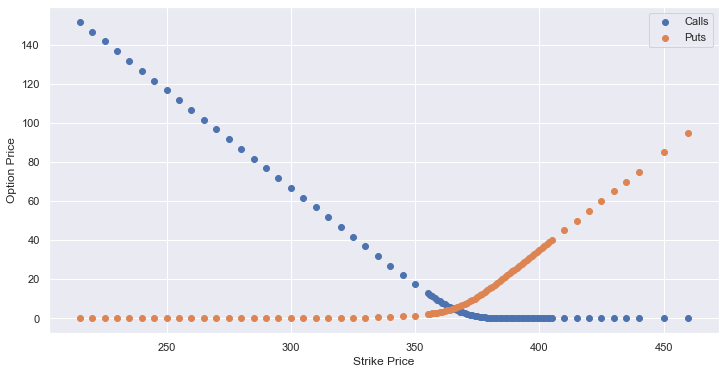

In [7]:
figure = plt.figure(figsize=(12, 6))

plt.scatter(spy_opts['strike'], spy_opts['call_mid'], label='Calls')
plt.scatter(spy_opts['strike'], spy_opts['put_mid'], label='Puts')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.legend()

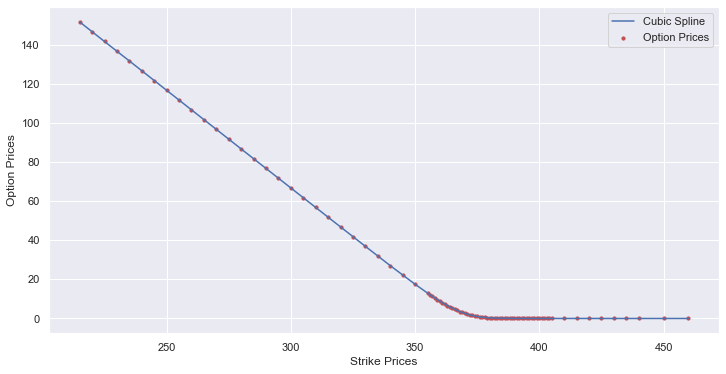

In [8]:
c_opt_s = CubicSpline(spy_opts['strike'], spy_opts['call_mid'])

figure = plt.figure(figsize=(12, 6))
plt.plot(spy_opts['strike'], c_opt_s(spy_opts['strike']), label='Cubic Spline')
plt.scatter(spy_opts['strike'], spy_opts['call_mid'], s=10, color='r', label='Option Prices')
plt.xlabel('Strike Prices')
plt.ylabel('Option Prices')
plt.legend()

In [9]:
def calc_pdf_price(strikes, C, tau, r):
    c_prime = np.gradient(C, strikes)
    c_pprime = np.gradient(c_prime, strikes)
    
    return np.exp(tau*r)*c_pprime

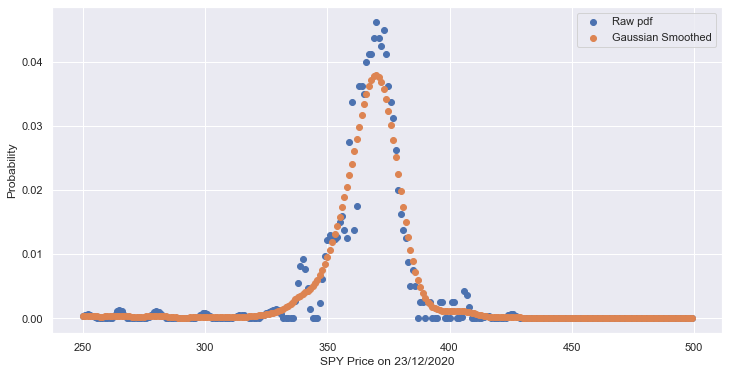

In [10]:
from scipy.ndimage import gaussian_filter1d
r = 0.02
tau = 9/253

fstrikes = np.arange(250, 500)

pp_pdf = calc_pdf_price(fstrikes, c_opt_s(fstrikes), tau, r)
pp_pdf = pd.Series(pp_pdf)
pp_pdf_copy = pp_pdf
pp_pdf_copy.loc[pp_pdf_copy < 0] = 0
pp_pdf_copy = gaussian_filter1d(pp_pdf, 5)

figure = plt.figure(figsize=(12, 6))

plt.scatter(fstrikes, pp_pdf, label='Raw pdf')
plt.scatter(fstrikes, pp_pdf_copy, label='Gaussian Smoothed')
plt.xlabel('SPY Price on 23/12/2020')
plt.ylabel('Probability')
plt.legend()

In [11]:
sum(fstrikes*pp_pdf)

382.44666680865106

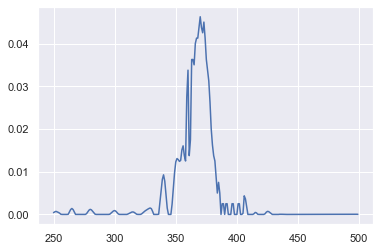

In [12]:
pp_pdf_c = CubicSpline(fstrikes, pp_pdf)
plt.plot(fstrikes, pp_pdf_c(fstrikes))

In [15]:
samples = []

for i in range(len(fstrikes)):
    n = int(pp_pdf_copy[i]*100000)
    curr = [fstrikes[i]]*n
    samples.extend(curr)
    
# samples

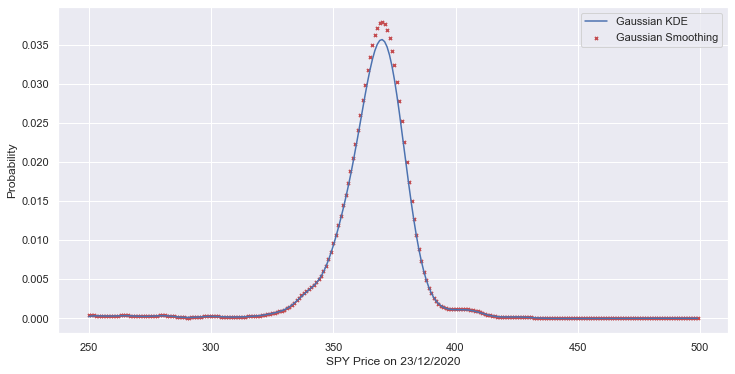

In [16]:
figure = plt.figure(figsize=(12, 6))

plt.plot(fstrikes, scipy.stats.gaussian_kde(samples).pdf(fstrikes), label='Gaussian KDE')
plt.scatter(fstrikes, pp_pdf_copy, s=10, marker='x', label='Gaussian Smoothing', c='r')
plt.xlabel('SPY Price on 23/12/2020')
plt.ylabel('Probability')
plt.legend()

Implied Volatility Estimation

In [20]:
spy_opts.loc[spy_opts['strike'] > 350].loc[spy_opts['strike'] < 370]

,strike,call_mid,put_mid
28,355,12.990,2.195
29,356,12.130,2.370
30,357,11.290,2.560
31,358,10.460,2.765
32,359,9.645,2.995
33,360,8.840,3.245
34,361,8.110,3.515
35,362,7.355,3.815
36,363,6.630,4.140
37,364,5.940,4.500


In [64]:
from scipy.stats import norm

# def newton_IV(S, K, tau, C, r, sigma):
#     d1 = (np.log(S/K) + (r+0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
#     d2 = d1 - (sigma*np.sqrt(tau))
    
#     f = S*scipy.stats.norm.cdf(d1, 0.0, 1.0) - K*np.exp(-r*tau)*scipy.stats.norm.cdf(d2, 0.0, 1.0) - C
    
#     vega = S*scipy.stats.norm.pdf(d1)*np.sqrt(tau)
# #     (1/np.sqrt(2*np.pi))*S*np.sqrt(tau)*np.exp(-(scipy.stats.norm.pdf(d1, 0.0, 1.0)**2)*0.5)
    
#     tol = 1e-10
#     x0 = sigma
#     xn = x0
#     xo = x0 - 1
    
#     while abs(xn - xo) > tol:
#         xo = xn
#         xn = (xn - f - C)/vega
        
#     return abs(xn)

# newton_IV(366.42, 365, tau, 5.295, 0.02, 2)

def call_val(S, K, sigma, tau=0, r=0):
    # use np.multiply and divide to handle divide-by-zero
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(tau)) * (np.log(S/K) + (r+sigma**2 / 2) * tau)
        d2 = d1 - sigma * np.sqrt(tau)
    return np.multiply(norm.cdf(d1),S) - np.multiply(norm.cdf(d2), K * np.exp(-r * tau))

def call_vega(S, K, sigma, tau=0, r=0):
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(tau)) * (np.log(S/K) + (r+sigma**2 / 2) * tau)
    return np.multiply(S, norm.pdf(d1)) * np.sqrt(tau)

def bs_iv(price, S, K, tau=0, r=0, precision=1e-4, initial_guess=0.2, max_iter=1000, verbose=False):
    iv = initial_guess
    for _ in range(max_iter):
        P = call_val(S, K, iv, tau, r)
        diff = price - P
        if abs(diff) < precision:
            return iv
        grad = call_vega(S, K, iv, tau, r)
        iv += diff/grad     
    if verbose:
        print(f"Did not converge after {max_iter} iterations")
    return iv


c_test = call_val(100, 110, 0.2, tau=1)
print(c_test)

4.292010941409885


In [82]:
iv_set = []

for i in range(len(spy_opts['strike'])):
    curr_iv = bs_iv(spy_opts.iloc[i]['call_mid'], S=366.42, K=spy_opts.iloc[i]['strike'], tau=tau, r=0.02)
    iv_set.append(float(curr_iv))
    
spy_opts['call_iv'] = iv_set
spy_opts = spy_opts.dropna()

<ipython-input-64-66a50830a666>:45: RuntimeWarning: divide by zero encountered in double_scalars
  iv += diff/grad
<ipython-input-64-66a50830a666>:28: RuntimeWarning: invalid value encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(tau)) * (np.log(S/K) + (r+sigma**2 / 2) * tau)
<ipython-input-64-66a50830a666>:34: RuntimeWarning: invalid value encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(tau)) * (np.log(S/K) + (r+sigma**2 / 2) * tau)


Text(0, 0.5, 'Implied Volatility')

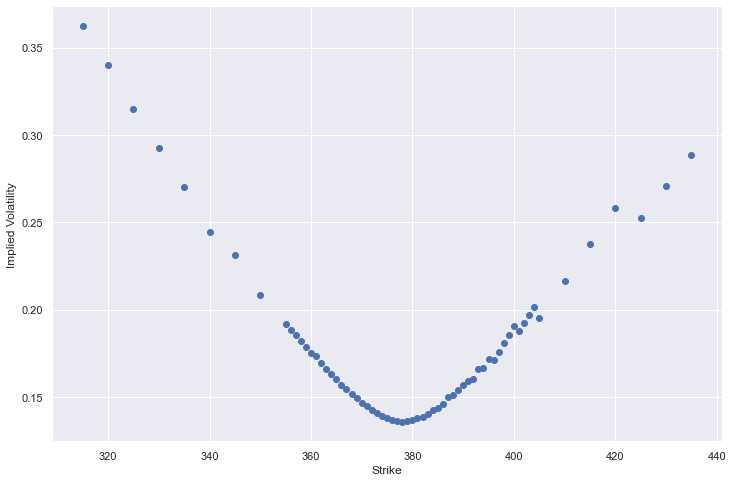

In [84]:
figure = plt.figure(figsize=(12, 8))

plt.scatter(spy_opts['strike'], spy_opts['call_iv'])
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')

<ipython-input-94-1c6b6013fff2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy_opts['call_iv_gauss'] = gaussian_filter1d(spy_opts['call_iv'], 0.8)


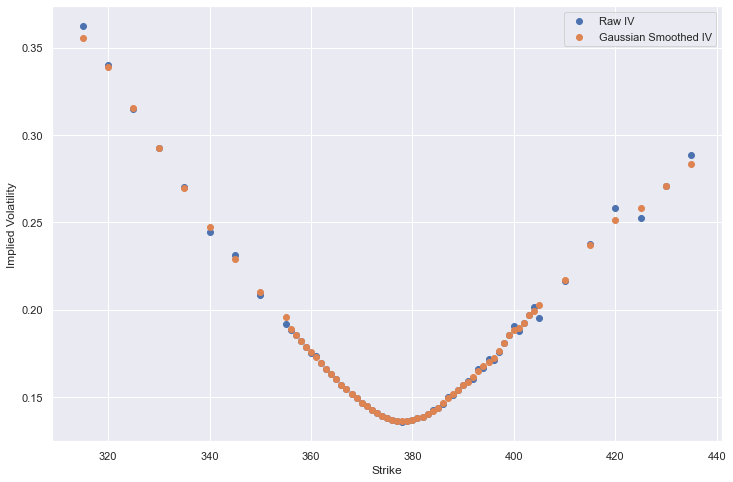

In [94]:
spy_opts['call_iv_gauss'] = gaussian_filter1d(spy_opts['call_iv'], 0.8)

figure = plt.figure(figsize=(12, 8))

plt.scatter(spy_opts['strike'], spy_opts['call_iv'], label='Raw IV')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.scatter(spy_opts['strike'], spy_opts['call_iv_gauss'], label='Gaussian Smoothed IV')
plt.legend()

<ipython-input-103-60b6fecc6bd8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy_opts['spline_iv'] = iv_spline(spy_opts['strike'])


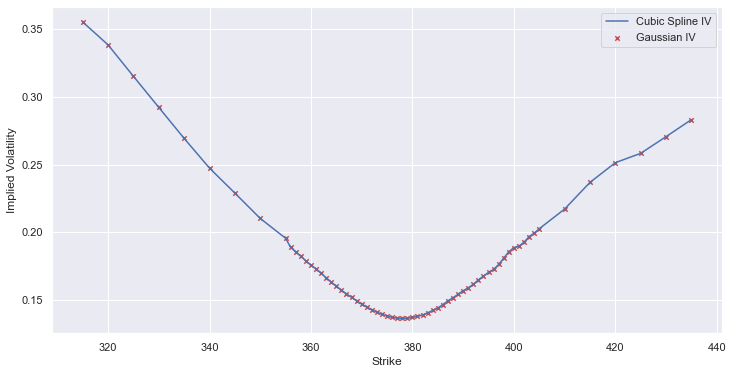

In [103]:
iv_spline = CubicSpline(spy_opts['strike'], spy_opts['call_iv_gauss'])
spy_opts['spline_iv'] = iv_spline(spy_opts['strike'])

figure = plt.figure(figsize=(12, 6))

plt.plot(spy_opts['strike'], spy_opts['spline_iv'], label='Cubic Spline IV')
plt.scatter(spy_opts['strike'], spy_opts['call_iv_gauss'], s=20, marker='x', label='Gaussian IV', color='r')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.legend()

In [108]:
iv_value = call_val(366.42, spy_opts['strike'], spy_opts['spline_iv'], tau=tau, r=0.02)

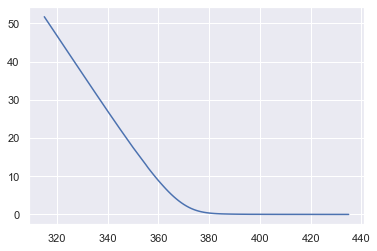

In [110]:
plt.plot(spy_opts['strike'], iv_value)

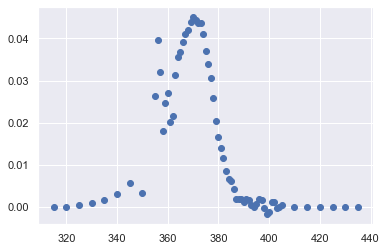

In [114]:
iv_pdf = calc_pdf_price(spy_opts['strike'], iv_value, tau, r)

plt.scatter(spy_opts['strike'], iv_pdf)

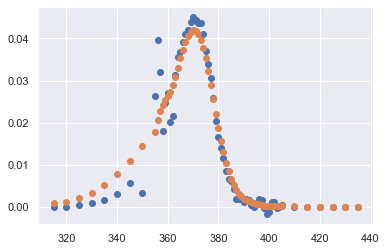

In [116]:
iv_pdf_gauss = gaussian_filter1d(iv_pdf, 3)
plt.scatter(spy_opts['strike'], iv_pdf)
plt.scatter(spy_opts['strike'], iv_pdf_gauss)

In [118]:
samples_iv = []

strikes = spy_opts['strike']

for i in range(len(strikes)):
    n = int(iv_pdf_gauss[i]*100000)
    curr = [strikes.iloc[i]]*n
    samples_iv.extend(curr)
    
samples_iv

[315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 315,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320,
 320

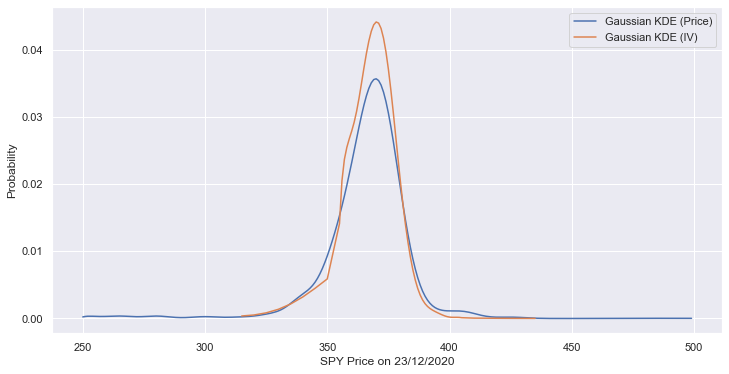

In [124]:
figure = plt.figure(figsize=(12, 6))

plt.plot(fstrikes, scipy.stats.gaussian_kde(samples).pdf(fstrikes), label='Gaussian KDE (Price)')
plt.plot(strikes, scipy.stats.gaussian_kde(samples_iv).pdf(strikes), label='Gaussian KDE (IV)')
# plt.scatter(fstrikes, pp_pdf_copy, s=10, marker='x', label='Gaussian Smoothing', c='r')
plt.xlabel('SPY Price on 23/12/2020')
plt.ylabel('Probability')
plt.legend()

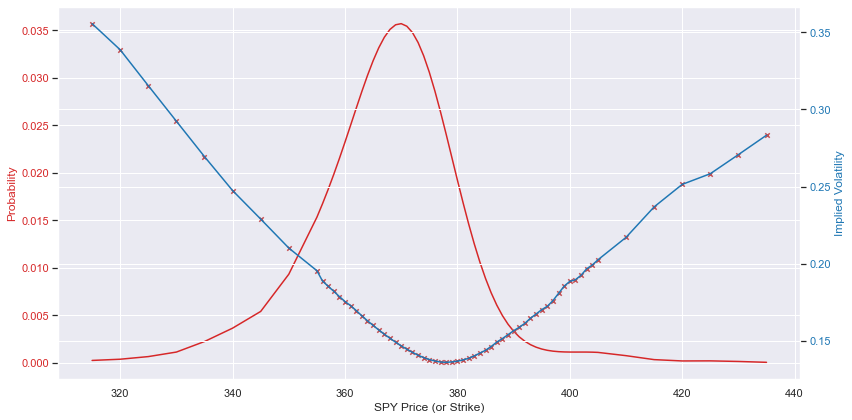

In [128]:
fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:red'
ax1.set_xlabel('SPY Price (or Strike)')
ax1.set_ylabel('Probability', color=color)
ax1.plot(strikes, scipy.stats.gaussian_kde(samples).pdf(strikes), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Implied Volatility', color=color)  # we already handled the x-label with ax1
ax2.plot(spy_opts['strike'], spy_opts['spline_iv'], label='Cubic Spline IV', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.scatter(spy_opts['strike'], spy_opts['call_iv_gauss'], s=20, marker='x', label='Gaussian IV', color='r')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()